# Anharmonic frequency shifts of normal modes in five-wire trap

The following notebook presents calculatino of anharmonic modes of 5 ion crystal in a five-wire planar trap.

Contents:

1) five-wire trap initialization  
2) Simulation of 3 ions, single species  
3) Normal modes calculation  
4) Anharmonic modes calculation


In [1]:
from __future__ import division
import pylion as pl
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt, numpy as np, scipy.constants as ct
from mpl_toolkits.mplot3d import Axes3D
from electrode import (System, PolygonPixelElectrode, PointPixelElectrode, shaped)

import sion as sn

## Trap initialization

The following block initializes the n-wire trap - a planar trap with n parallel RF lines, which can influence anharmonicity and stability of the trap potential, using a *sion* function. The following parameters are optimized to maximize the anharmonicity for this geometry.

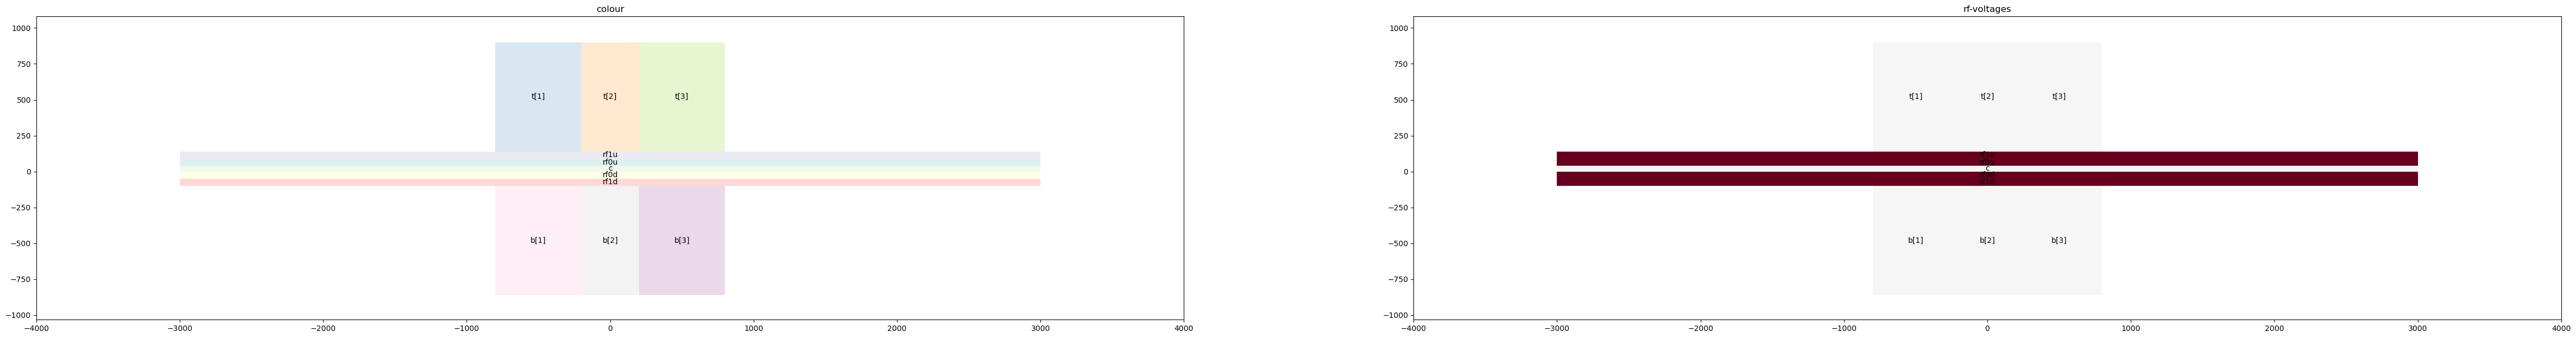

In [2]:
# define trap with large anharmonicity 
L = 1e-6 # length scale
Vrf = 100. # RF peak voltage in V
mass = 40*ct.atomic_mass # ion mass
Z = 1*ct.elementary_charge # ion charge
Omega = 2*np.pi*150e6 # RF frequency in rad/s
Urf = Vrf * np.sqrt(Z / mass) / (2 * L * Omega)
scale = Z / ((L * Omega) ** 2 * mass)

# parameters of trap
DCtop = [[760, 600],[1000-240, 400],[760, 600] ]  # Array of lengths and widths of Top electrodes
DCbottom = [[760, 600],[1000-240, 400],[760, 600] ]  # Array of lengths and widths of Bottom electrodes
cwidth = 40  # Width of central dc electrode
clength = 6000 # length of central dc electrode
boardwidth = 10  # width of gaps between electrodes
rfwidth = np.array([[50, 50], [50, 50]])
rflength = 6000  # length of rf electrodes
n_rf = 2
Urf = [[Urf, Urf], [Urf, Urf]]

#s, RF_electrodes, DC_electrodes = sn.five_wire_trap_design(Urf, DCtop, DCbottom, cwidth, clength, boardwidth, rftop, rflength, rfbottom, need_coordinates = True, need_plot = True)
s, RF_electrodes, DC_electrodes = sn.n_rf_trap_design(Urf, DCtop, DCbottom, cwidth, rfwidth, rflength, n_rf = n_rf , L = 1e-6, need_coordinates = True, need_plot = True)

## Trap potential analysis

The following block determines the trap minimum point and secular frequencies of ions in the trap. Additionally, the pseudopotential of the trap is presented on 3 plots, demonstrating the cross-sections of potential colormap through the trap minimum.

In [3]:
x0 = np.array(s.minimum((0., 0, 30), axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG"))
dc_set = 0.3*np.array([15, -15,  15, 15, -15, 15,  -3.408]) 

u_set = np.concatenate((np.zeros(2*n_rf), dc_set))

with s.with_voltages(dcs = u_set, rfs = None):
    x1 = np.array(s.minimum( x0, axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG"))
    print('Potential minimum:', x1)
    print('Distance from RF minimum:',x1-x0)
    curv_z, mod_dir=s.modes(x1,sorted=False)
    omega_sec = np.sqrt(Z*curv_z/mass)/(L*2*np.pi) * 1e-6
    print("Secular frequencies: (%.4g, %.4g, %.4g) MHz" % (omega_sec[0],omega_sec[1],omega_sec[2]))
    print("In directions\na:", mod_dir[0],"\nb:", mod_dir[1],"\nc:", mod_dir[2] )


Potential minimum: [7.39262461e-17 2.00000031e+01 4.71879315e+01]
Distance from RF minimum: [ 7.39163138e-17  3.53557512e-05 -1.77515573e+00]
Secular frequencies: (1.056, 3.838, 4.532) MHz
In directions
a: [ 1. -0.  0.] 
b: [ 0.00000000e+00 -8.63504195e-07  1.00000000e+00] 
c: [ 0.00000000e+00 -1.00000000e+00 -8.63504195e-07]


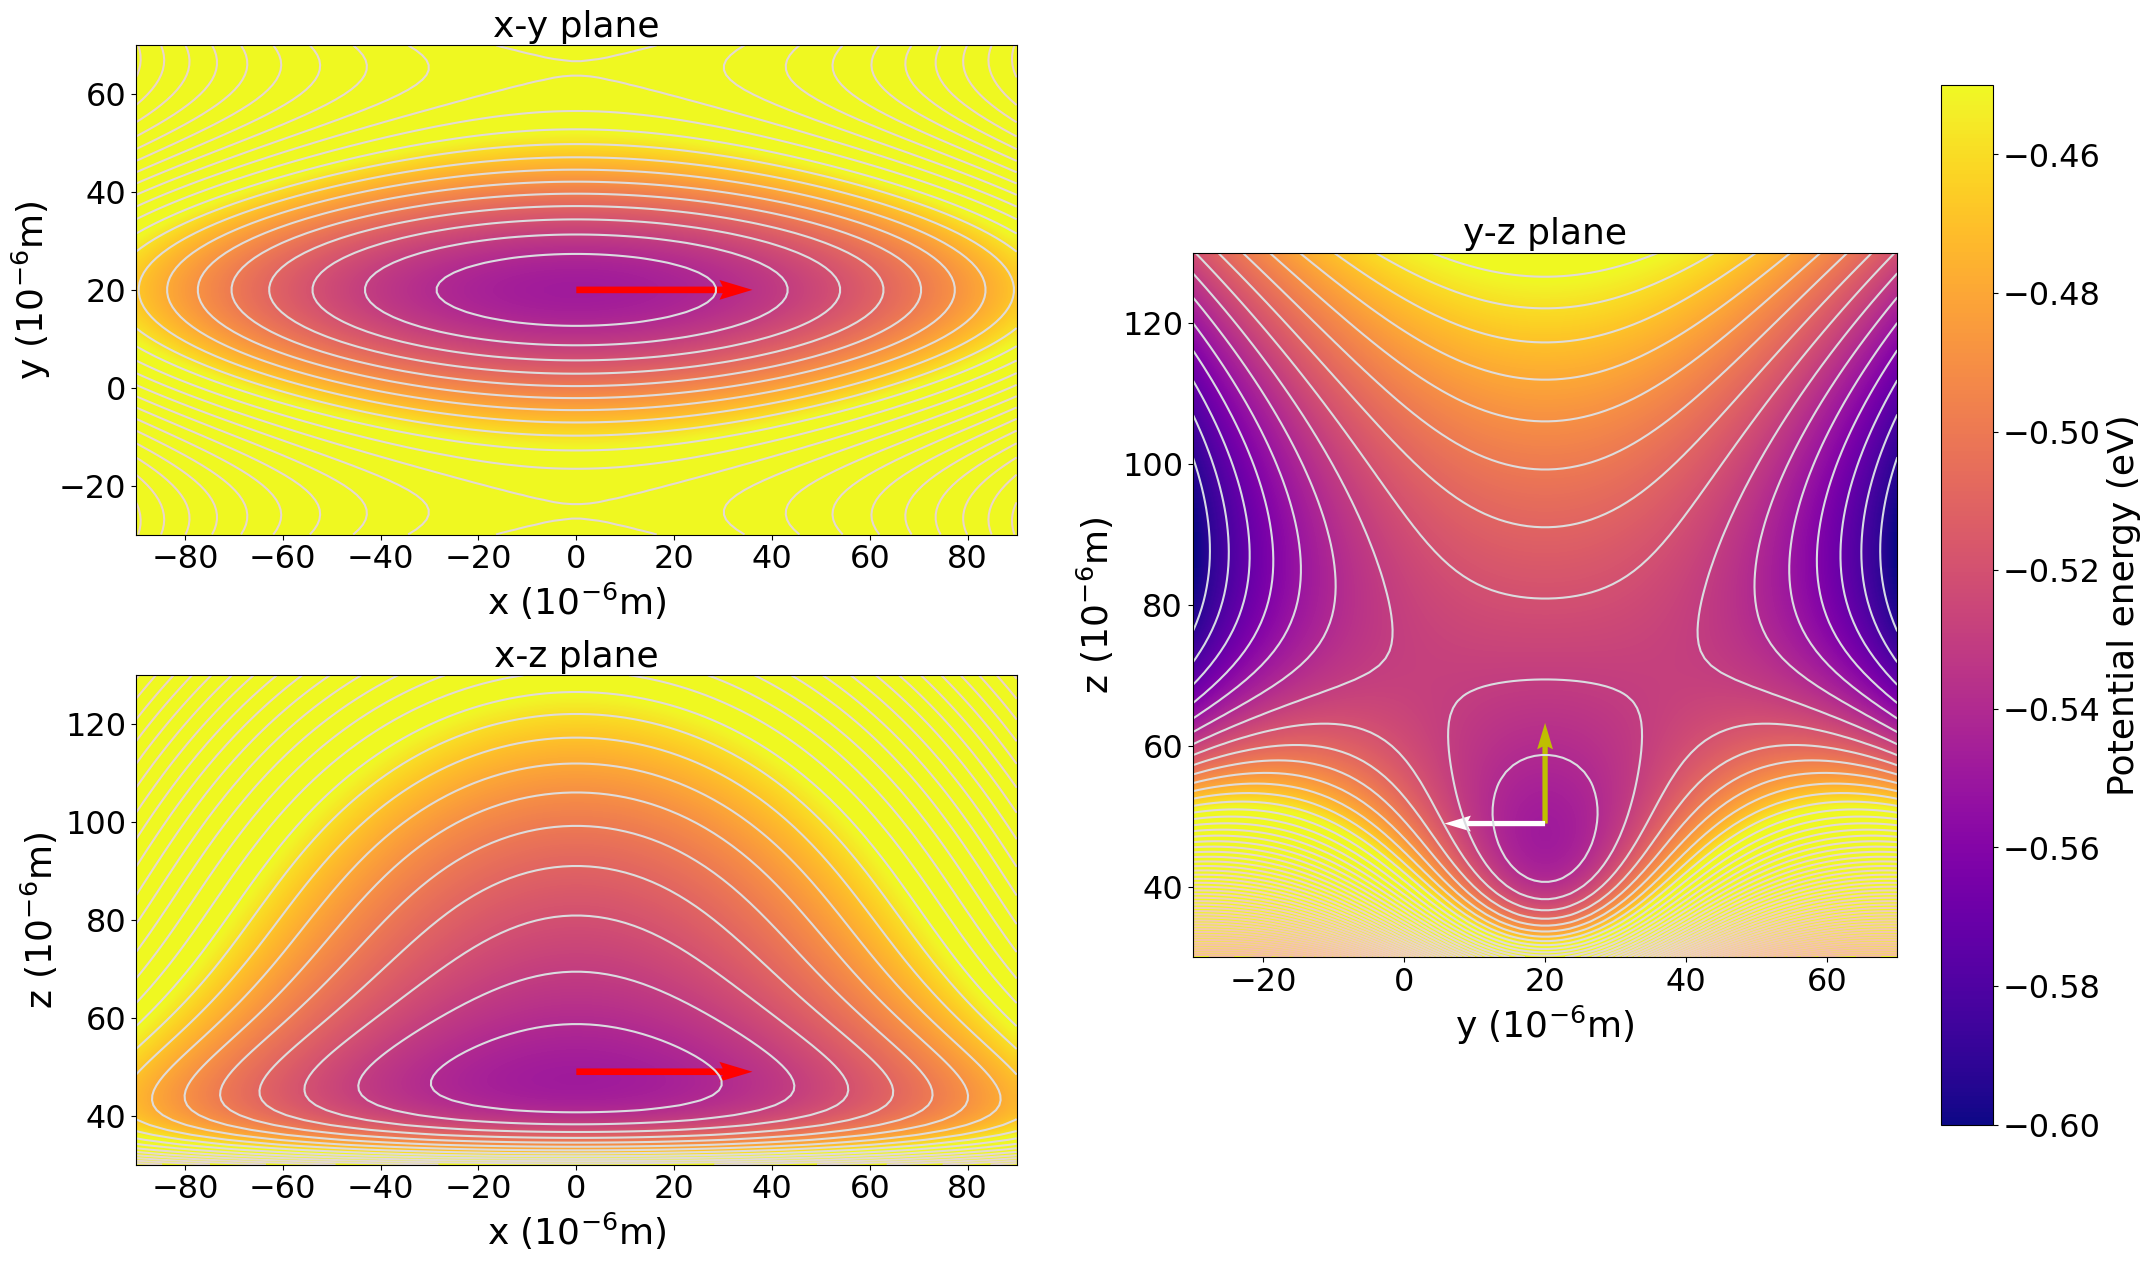

In [4]:
 # #Plot the pseudopotential
with s.with_voltages(dcs = u_set, rfs = None):
    # in with_voltages, all electrodes have to be listed in an array
    # (the array for dcs also contains the RF electrode)
    
    # 2D plot settings
    
    n=100 # resolution of meshgrid = resolution of 2D plots
    xmin, xmax = -90, 90 #set the plot ranges
    ymin, ymax = -30, 70
    zmin, zmax = 30, 130
    x_cut, y_cut, z_cut = x0[0], x0[1], x0[2]# position of the yz-, xz-, xy- crossection
    v = np.arange(-2, 1, 0.01)# set the range for contour lines (range in eV)
    v_min, v_max = -0.6, -0.45 # set the range for colour map (range in eV)
    fs = 26 #set the fontsize
    ls = 23 #set the labelsize
    fig = plt.figure()
    fig.set_size_inches(25,15)
    
    # x-y cross section
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax1.set_title("x-y plane" ,fontsize=fs)
    ax1.set_xlabel('x ($10^{-6}$m)',fontsize=fs)
    ax1.set_ylabel('y ($10^{-6}$m)',fontsize=fs)
    ax1.tick_params(axis='x', labelsize=ls)
    ax1.tick_params(axis='y', labelsize=ls)
    xyz = np.mgrid[xmin:xmax:1j*n, ymin:ymax:1j*n, z_cut:z_cut+1]
    pot = shaped(s.potential)(xyz)
    x, y, p = (_.reshape(n, n) for _ in (xyz[0], xyz[1], pot))
    CS=ax1.contour(x, y, p, v, cmap=plt.cm.coolwarm)
    im = ax1.imshow(p.T,cmap='plasma', origin='lower', vmin=v_min, vmax=v_max, extent=(xmin,xmax,ymin,ymax))
    im.set_interpolation('bilinear')
    
    # x-z cross section
    ax2 = plt.subplot2grid((2,2), (1,0))
    ax2.set_title("x-z plane" ,fontsize=fs)
    ax2.set_xlabel('x ($10^{-6}$m)',fontsize=fs)
    ax2.set_ylabel('z ($10^{-6}$m)',fontsize=fs)
    ax2.tick_params(axis='x', labelsize=ls)
    ax2.tick_params(axis='y', labelsize=ls)
    xyz = np.mgrid[xmin:xmax:1j*n, y_cut:y_cut+1, zmin:zmax:1j*n]
    pot = shaped(s.potential)(xyz)
    x, z, p = (_.reshape(n, n) for _ in (xyz[0], xyz[2], pot))
    CS=ax2.contour(x, z, p, v, cmap=plt.cm.coolwarm)
    im = ax2.imshow(p.T,cmap='plasma', origin='lower', vmin=v_min, vmax=v_max, extent=(xmin,xmax,zmin,zmax))
    im.set_interpolation('bilinear')
    
    # y-z cross section
    ax3 = plt.subplot2grid((2,2), (0,1), rowspan=2)
    ax3.set_title("y-z plane" ,fontsize=fs)
    ax3.set_xlabel('y ($10^{-6}$m)',fontsize=fs)
    ax3.set_ylabel('z ($10^{-6}$m)',fontsize=fs)
    ax3.tick_params(axis='x', labelsize=ls)
    ax3.tick_params(axis='y', labelsize=ls)
    xyz = np.mgrid[x_cut:x_cut+1, ymin:ymax:1j*n, zmin:zmax:1j*n]
    pot = shaped(s.potential)(xyz)
    x, z, p = (_.reshape(n, n) for _ in (xyz[1], xyz[2], pot))
    CS=ax3.contour(x, z, p, v, cmap=plt.cm.coolwarm)
    im = ax3.imshow(p.T,cmap='plasma', origin='lower', vmin=v_min, vmax=v_max, extent=(ymin,ymax,zmin,zmax))
    im.set_interpolation('bilinear') 
    
    # add colorbar
    cb = fig.colorbar(im, ax=ax3, shrink=0.9)
    cb.ax.tick_params(labelsize=ls)
    cb.set_label('Potential energy (eV)', fontsize = fs)
    
    #add secular frequencies
    #change color and scale (the fewer, the longer the arrow)
    ax1.quiver(*[[x0[0]],[x0[1]]], mod_dir[0][0], mod_dir[0][1], color=['r'], scale = 5)
    ax2.quiver(*[[x0[0]],[x0[2]]], mod_dir[0][0], mod_dir[0][2], color=['r'], scale = 5)
    ax3.quiver(*[[x0[1]],[x0[2]]], mod_dir[1][1], mod_dir[1][2], color=['y'], scale = 7)
    ax3.quiver(*[[x0[1]],[x0[2]]], mod_dir[2][1], mod_dir[2][2], color=['w'], scale = 7)

## Stability

To confirm, that ions will be stable in this potential configuration, the stability analysis is carried out.

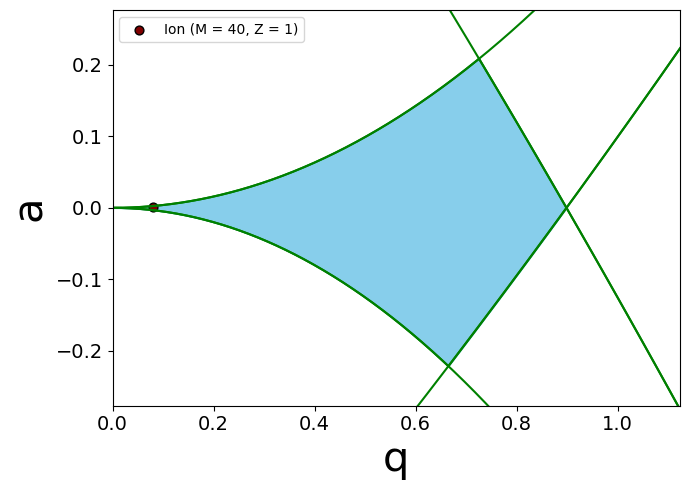

{'Ion (M = 40, Z = 1)': {'a': 0.000750329574525775, 'q': 0.08042419610089989},
 'α': 1.2640612287130737,
 'θ': 1.0430812835693365e-07,
 'Range of achievable a': [-0.2211861113258375, 0.20836424930466374],
 'Critical q': 0.8989794855663589}


In [5]:
rf_set = [Vrf, Vrf, Vrf, Vrf]
with s.with_voltages(dcs = u_set, rfs = rf_set):
    params = sn.stability(s, mass, Omega, Z, minimum = x1) 

import pprint
pprint.pprint(params, sort_dicts=False)

## Anharmonic length

The surface trap potential is influenced by anharmonic terms, mostly hexapole and octopole anharmonicity. In 1D simplified picture, such effects can be expressed in terms of anharmonic length $l_2, l_3, l_4$. The potential is then modified as follows:

$ V(z) = \frac{\text{Z}e}{8\pi\epsilon_0l_2^3}z^2\left( 1 + \frac{z}{l_3} + \left(\frac{z}{l_4}\right) ^2 \right). $

Then, the anharmonic frequency shifts can be estimated through the relation of $\left(\frac{l_2}{l_3}\right) ^2 + \left(\frac{l_2}{l_4}\right) ^2 $. The *sion.anharmonics* function finds the anharmonic lengths for the considered trap configuration, for the desired axis of oscillation.

In [7]:
minimums = [x1]
axis = 1 # this is vertical z axis in this example 

with s.with_voltages(dcs = u_set, rfs = None):
    scales = sn.anharmonics(s, minimums, axis, L)
    
scales = scales[0]
print('l2 =', scales[0], '\nl3 =', scales[1], '\nl4 =', scales[2])

l2 = 1.8142765147492302e-06 
l3 = 0.002146966059174085 
l4 = -5.110571958032058e-05


## Ion dynamics simulation

Since the simulation considers the full potential expression, the resulting equilibrium ion positions are determined considering the effects of anharmonicity.

In [405]:
ion_number = 3

#insert your path to this file here
name = Path('anharmonic_modes.ipynb').stem

sim = pl.Simulation(name)

#ions' declaration
ions = {'mass': 40, 'charge': 1}

#placing ion in random cloud near minimum
positions = sn.ioncloud_min(x1*L, ion_number, 5e-6)
sim.append(pl.placeions(ions, positions))

#declaration of a five wire trap
sim.append(sn.polygon_trap([Omega,Omega,Omega,Omega], rf_set, dc_set, RF_electrodes, DC_electrodes))

#cooling simulation
sim.append(pl.langevinbath(0, 1e-7))

#files with simulation information
sim.append(pl.dump('anharmonic_positions.txt', variables=['x', 'y', 'z'], steps=10))
sim.append(pl.evolve(1e6))
sim.execute()

Reducing timestep to 5.305164769729845e-11 sec
LAMMPS (3 Mar 2020)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (../comm.cpp:94)
  using 1 OpenMP thread(s) per MPI task
Created orthogonal box = (-0.01 -0.01 -0.01) to (0.01 0.01 0.01)
  1 by 1 by 1 MPI processor grid
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Setting atom values ...
  3 settings made for charge
3 atoms in group 1
3 atoms in group nonRigidBody
Neighbor list info ...
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 11
  ghost atom cutoff = 11
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair coul/cut, perpetual
      attributes: half, newton on
      pair build: half/nsq/newton
      stencil: none
      bin: none
Setting up Verlet run ...
  Unit style    : si
  Current step  : 0
  Time step     : 5.30516e-11
Per MPI rank memory allocation (min/avg/max) = 4.78 | 4.78 | 4.78 Mbytes
Step CPU 
       0    

C:\Users\User_A\anaconda3\lib\site-packages\pylion-0.5.2-py3.9.egg\pylion\utils.py:95: UserWarning: Caller source not saved. Are you running the simulation from the REPL?
  warnings.warn(


Final positions of ions:
 [[-4.62117e-06  2.00000e-05  4.71726e-05]
 [-2.20031e-20  2.00000e-05  4.71906e-05]
 [ 4.62117e-06  2.00000e-05  4.71726e-05]]


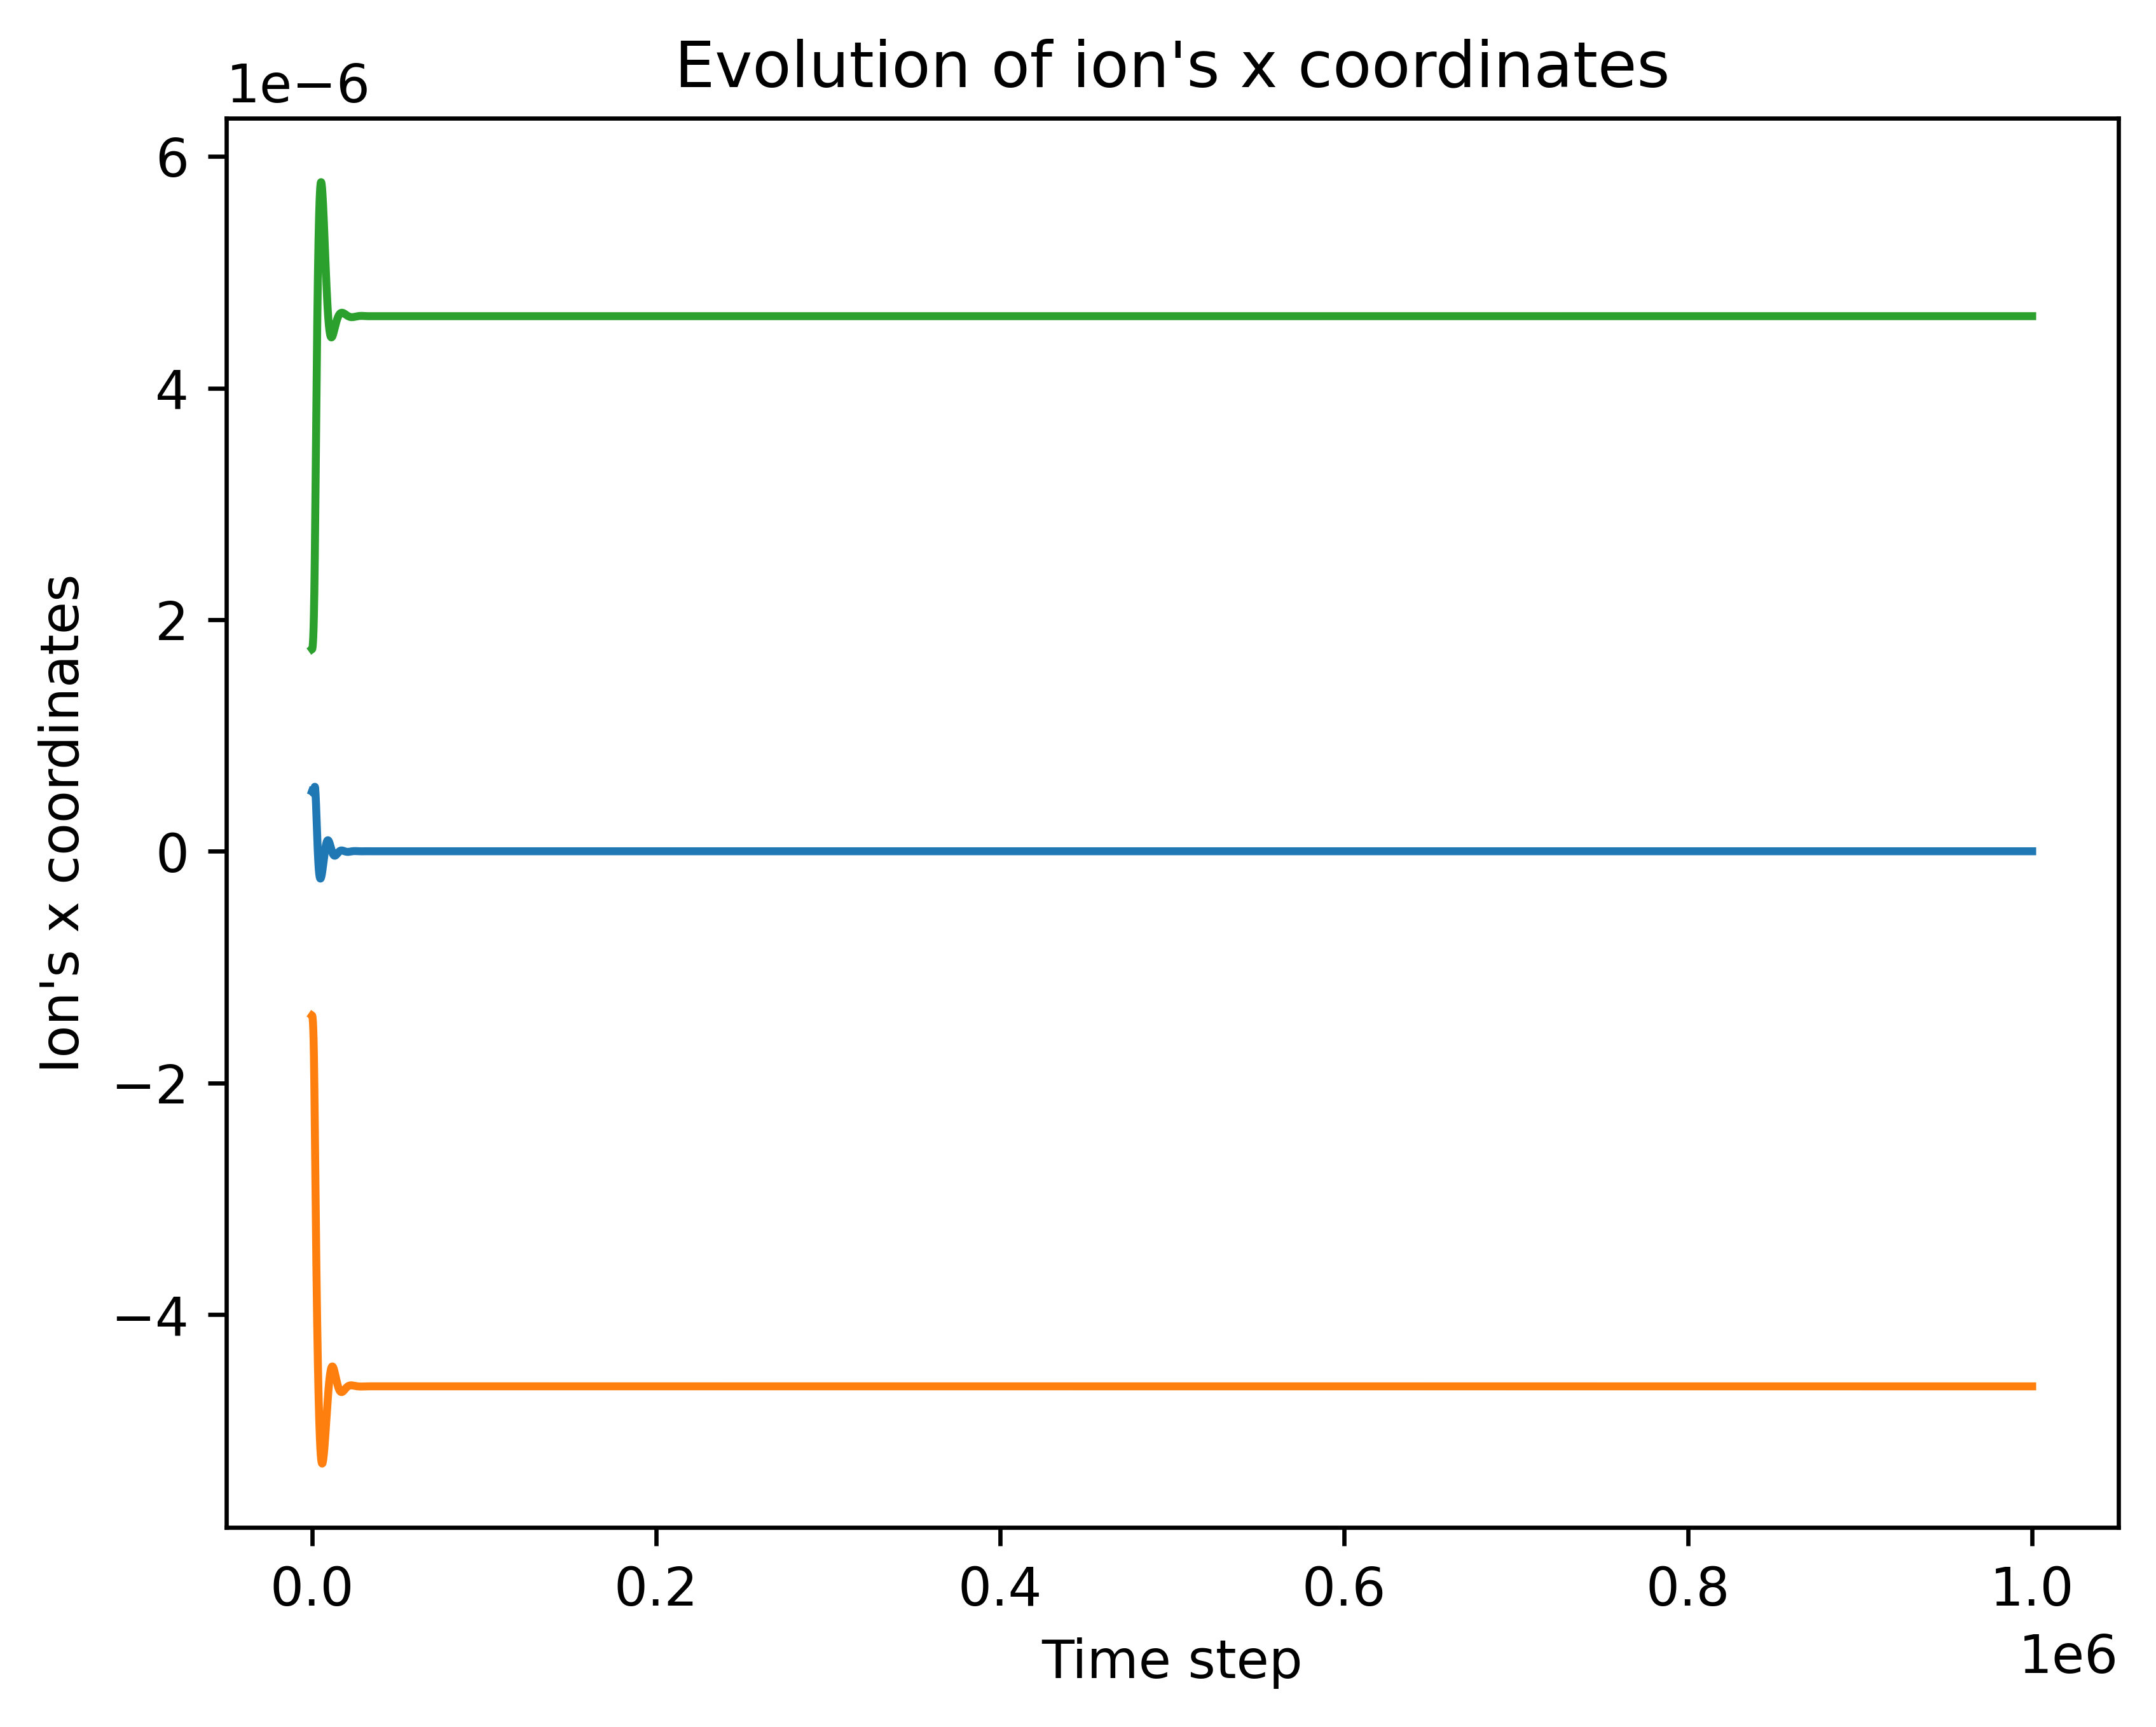

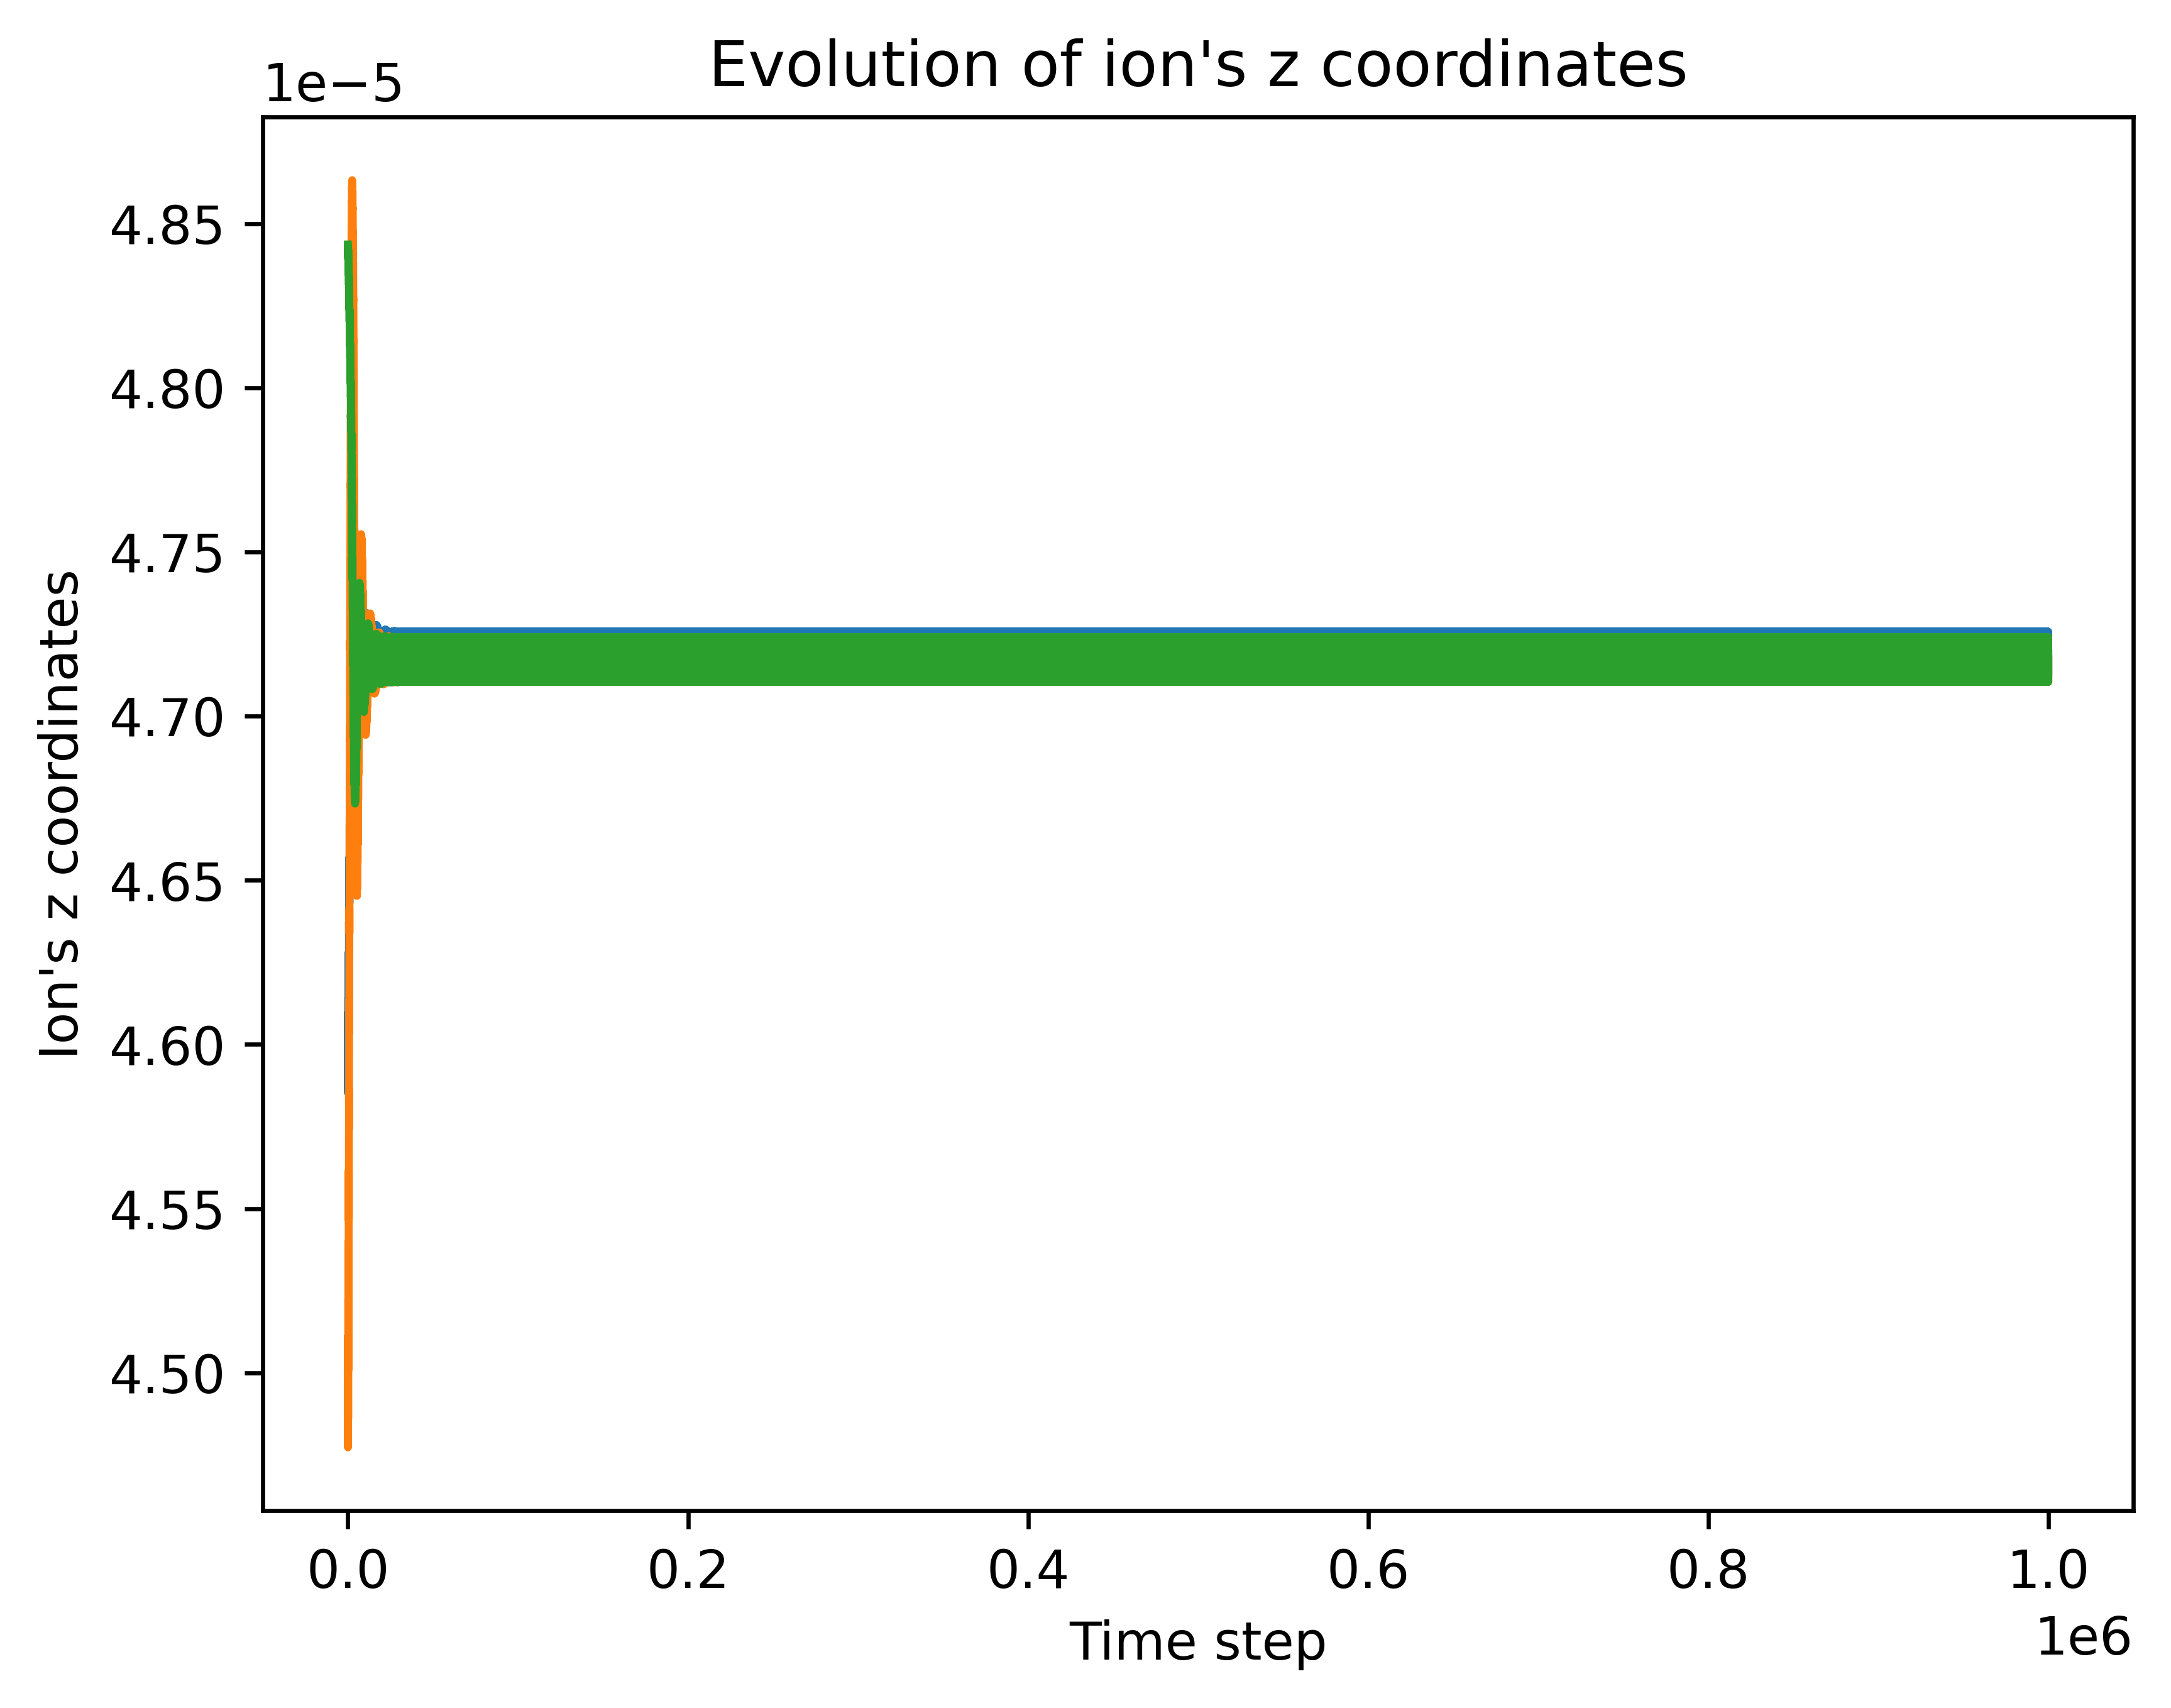

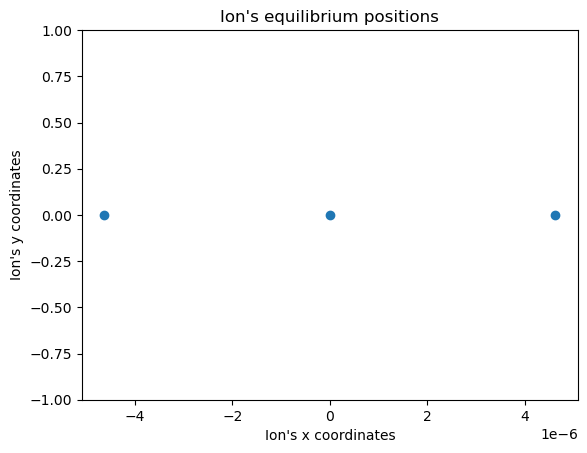

equilibrium ion positions:
 [[-4.62117000e-06  2.00000000e-05  4.71727735e-05]
 [-3.18855818e-19  2.00000000e-05  4.71906941e-05]
 [ 4.62117000e-06  2.00000000e-05  4.71727735e-05]]


In [8]:
ion_number = 3
_, data = pl.readdump('anharmonic_positions.txt')

final_x = data[-1, :, 0]
final_y = data[-1, :, 1]
final_z = data[-1, :, 2]

ion_positions = np.zeros([ion_number, 3])
sort = np.argsort(final_x)

k=0
for i in sort:
    ion_positions[k] = np.array([final_x[i], final_y[i], final_z[i]])
    k+=1

print('Final positions of ions:\n', ion_positions)


# Plot of ion crystal evolution
plt.figure(dpi = 600)
for n in range(ion_number):
    plt.plot(np.arange(data.shape[0]) * 10 + 1, data[:, n, 0])
plt.title('Evolution of ion\'s x coordinates')
plt.xlabel('Time step')
plt.ylabel('Ion\'s x coordinates')
plt.show()

plt.figure(dpi = 600)
for n in range(ion_number):
    plt.plot(np.arange(data.shape[0]) * 10 + 1, data[:, n, 2])
plt.title('Evolution of ion\'s z coordinates')
plt.xlabel('Time step')
plt.ylabel('Ion\'s z coordinates')
plt.show()

# Plot of the final ion crystal configuration
plt.figure()
plt.scatter(data[-1, :, 0], data[-1, :, 1])
plt.title('Ion\'s equilibrium positions')
plt.xlabel('Ion\'s x coordinates')
plt.ylabel('Ion\'s y coordinates')
plt.ylim([-max(1, 1.2 * np.max(np.abs(data[-1, :, 1]))), max(1, 1.2 * np.max(np.abs(data[-1, :, 1])))])
plt.show()

equilibrium_positions = np.zeros([ion_number, 3])
k=0
for i in sort:
    equilibrium_positions[k] = np.array([np.mean(data[99000:, i, 0]), np.mean(data[99000:, i, 1]), np.mean(data[9500:, i, 2])])
    k+=1
equilibrium_positions = np.array(equilibrium_positions)
print('equilibrium ion positions:\n', equilibrium_positions)

# Testing anharmonic normal modes


## Harmonic normal modes

Given the ion crystal coordinates, the *sion.normal_modes()* function returns the calculated normal modes in harmonic approximation. The following block calculates normal modes, corresponding to all 3 principle axes, which appear in the form of the table (XX, XY, XZ),(YX, YY, YZ),(ZX, ZY, ZZ). It aligns to the linearly ordered ion chain up to 3rd order.

In [9]:
omegac = [omega_sec[0], omega_sec[2], omega_sec[1]]
omegas = np.array([omegac, omegac, omegac])*1e6  #convert to Hz
ion_masses = [mass, mass, mass]
harm_freqs, harm_modes = sn.normal_modes(equilibrium_positions, omegas, mass, reshape = True)

np.set_printoptions(suppress=True)
print('Harmonic freqs:\n', np.round(harm_freqs*1e-6, 2))
print('Harmonic modes:\n', np.round(harm_modes, 4))

Harmonic freqs:
 [1.06 1.83 2.54 4.23 4.41 4.53 3.47 3.69 3.84]
Harmonic modes:
 [[ 0.5774  0.5774  0.5774 -0.     -0.      0.     -0.      0.      0.    ]
 [-0.7071 -0.      0.7071 -0.     -0.      0.      0.0008 -0.0017  0.0008]
 [-0.4082  0.8165 -0.4082  0.     -0.     -0.      0.0018 -0.     -0.0018]
 [-0.     -0.      0.      0.4082 -0.8165  0.4082 -0.     -0.     -0.    ]
 [-0.     -0.      0.      0.7071  0.     -0.7071  0.      0.      0.    ]
 [ 0.      0.     -0.     -0.5774 -0.5774 -0.5774  0.      0.      0.    ]
 [ 0.0015 -0.     -0.0015  0.     -0.     -0.      0.4082 -0.8165  0.4082]
 [ 0.001  -0.002   0.001   0.     -0.      0.      0.7071  0.     -0.7071]
 [-0.      0.      0.     -0.      0.     -0.     -0.5774 -0.5774 -0.5774]]


## Anharmonic modes

Provided that the anharmonic terms are small, the modes can be still considered harmonic with some frequency shift, coming from anharmonic terms. The *sion.anharmonic_modes* function calculates the modes, corresponding to the harmonic ones with the frequency shift. We notice some increase in normal mode mixing along XZ axis.

In [11]:
np.set_printoptions(suppress=False)
anh_freqs, anh_modes = sn.anharmonic_modes(equilibrium_positions, ion_masses, s, rf_set, Omega, dc_set)

np.set_printoptions(suppress=True)
print('Anharmonic freqs:\n',np.round(anh_freqs*1e-6, 2), 'MHz')
print('Anharmonic modes:\n',np.round(anh_modes, 4))

Anharmonic freqs:
 [1.06 1.83 2.54 4.23 4.41 4.54 3.48 3.7  3.85] MHz
Anharmonic modes:
 [[ 0.5771  0.5774  0.5775 -0.      0.      0.      0.0017 -0.0026 -0.0069]
 [-0.7072 -0.0004  0.7069  0.      0.      0.     -0.0013 -0.0005 -0.0098]
 [-0.4084  0.8164 -0.4081 -0.      0.     -0.      0.001  -0.0091  0.008 ]
 [ 0.     -0.     -0.      0.405  -0.8198  0.405  -0.     -0.     -0.    ]
 [-0.     -0.     -0.      0.7071  0.     -0.7071  0.     -0.     -0.    ]
 [-0.      0.      0.      0.5797  0.5727  0.5797  0.      0.      0.    ]
 [-0.0016  0.0091 -0.0074  0.     -0.      0.     -0.4031  0.8218 -0.4025]
 [-0.0013  0.0006 -0.0098 -0.     -0.      0.      0.7074  0.0007 -0.7068]
 [-0.0021  0.0026  0.0074  0.     -0.      0.      0.5806  0.5697  0.5816]]


# Normal mode interaction matrix

Interaction matrces for both harmonic and anharmonic case. As expected from the "small anharmonicity" simplification, their interaction is very similar (up to sign flips).

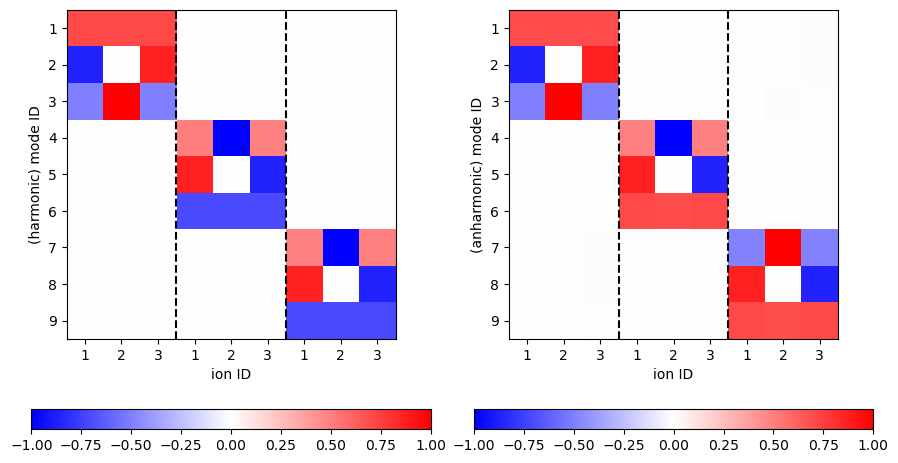

In [13]:
fig, ax = plt.subplots(1,2, figsize = (9, 5))
im1 = ax[1].imshow(anh_modes[:, :] / np.max(np.abs(anh_modes)), cmap='bwr', vmax = 1, vmin = -1)
# plt.xticks([0, 1, 2], [1, 2, 3])
# plt.yticks([0, 1, 2], [1, 2, 3])
im0 = ax[0].imshow(harm_modes[:, :] / np.max(np.abs(harm_modes)), cmap='bwr', vmax = 1, vmin = -1)

fig.colorbar(im0, ax=ax[0], orientation='horizontal')
fig.colorbar(im1, ax=ax[1], orientation='horizontal')
ax[0].axvline(2.5, color = 'k', linestyle = '--')
ax[0].axvline(5.5, color = 'k', linestyle = '--')
ax[1].axvline(2.5, color = 'k', linestyle = '--')
ax[1].axvline(5.5, color = 'k', linestyle = '--')

ax[0].set_xticks(range(9), [1,2,3,1,2,3,1,2,3])
ax[1].set_xticks(range(9), [1,2,3,1,2,3,1,2,3])
ax[0].set_yticks(range(9), range(1,10))
ax[1].set_yticks(range(9), range(1,10))

ax[0].set_xlabel('ion ID')
ax[0].set_ylabel('(harmonic) mode ID')
ax[1].set_xlabel('ion ID')
ax[1].set_ylabel('(anharmonic) mode ID')
plt.tight_layout()
plt.show() 

# Fourier analysis

We perform the Fourier analysis of the 3-ion motion, to determine the exact frequencies os oscillation in the trap. The following simulation is performed without cooling, and it corresponds to oscillation near equilibrium positions.

In [411]:
start_positions = []
for pos in equilibrium_positions:
    start_positions.append((pos + L*0.001*(np.random.rand(3)-np.ones(3))))
    
    
"""Simulation"""

#insert your path to this file here
name = Path("anharmonic_modes (2).ipynb").stem

si = pl.Simulation(name)

#ions' declaration
ions = {'mass': 40, 'charge': 1}

#placing ion in random cloud near minimum
si.append(pl.placeions(ions, start_positions))
#s.append(pl.langevinbath(1e-7, 1e-7))

#declaration of a five wire trap
si.append(sn.polygon_trap([Omega,Omega,Omega,Omega], rf_set, dc_set, RF_electrodes, DC_electrodes))

#files with simulation information
si.append(pl.dump('anharmonic_fourier.txt', variables=['x', 'y', 'z'], steps=1))
si.append(pl.evolve(2e6))
si.execute()

Reducing timestep to 5.305164769729845e-11 sec
LAMMPS (3 Mar 2020)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (../comm.cpp:94)
  using 1 OpenMP thread(s) per MPI task
Created orthogonal box = (-0.01 -0.01 -0.01) to (0.01 0.01 0.01)
  1 by 1 by 1 MPI processor grid
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Setting atom values ...
  3 settings made for charge
3 atoms in group 1
3 atoms in group nonRigidBody
Neighbor list info ...
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 11
  ghost atom cutoff = 11
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair coul/cut, perpetual
      attributes: half, newton on
      pair build: half/nsq/newton
      stencil: none
      bin: none
Setting up Verlet run ...
  Unit style    : si
  Current step  : 0
  Time step     : 5.30516e-11
Per MPI rank memory allocation (min/avg/max) = 4.78 | 4.78 | 4.78 Mbytes
Step CPU 
       0    

C:\Users\User_A\anaconda3\lib\site-packages\pylion-0.5.2-py3.9.egg\pylion\utils.py:95: UserWarning: Caller source not saved. Are you running the simulation from the REPL?
  warnings.warn(


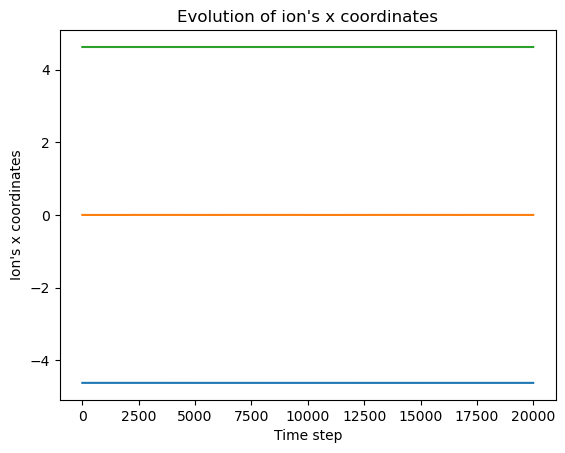

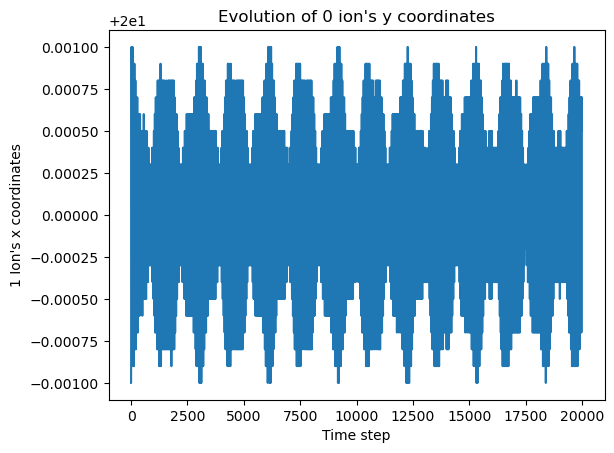

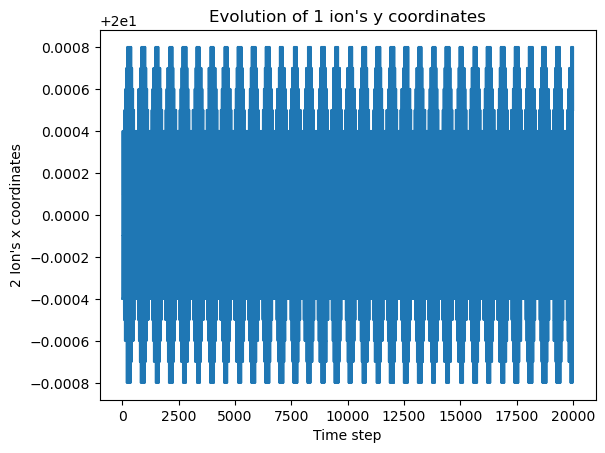

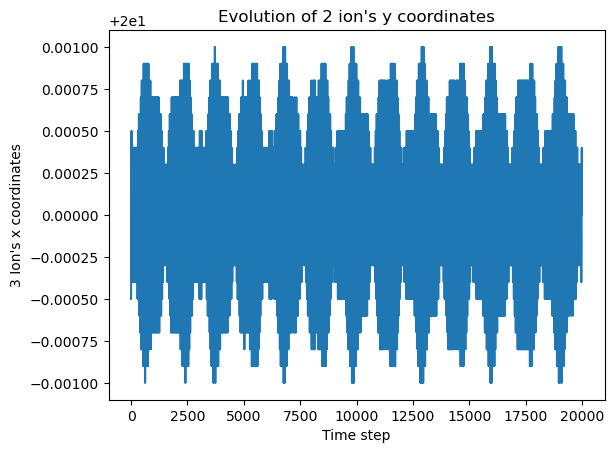

In [14]:
_, data = pl.readdump('anharmonic_fourier.txt')
data *= 1e6

plt.figure()
for n in range(ion_number):
    plt.plot(data[::100, n, 0])
plt.title('Evolution of ion\'s x coordinates')
plt.xlabel('Time step')
plt.ylabel('Ion\'s x coordinates')
plt.show()

for n in range(ion_number):
    plt.figure()
    plt.plot(data[::100, n, 1])
    plt.title('Evolution of ' + str(n) +' ion\'s y coordinates')
    plt.xlabel('Time step')
    plt.ylabel(str(n+1) +' Ion\'s x coordinates')
    plt.show()

In [15]:
x = data[:, :, 0]
y = data[:, :, 1]
z = data[:, :, 2]

timestep = 1/(20*Omega)
freqsfft = np.fft.fftfreq(data.shape[0], timestep)

normal_spectrum_x = []
normal_spectrum_y = []
normal_spectrum_z = []

for i in range(ion_number):
    ion_spectrum_x = np.fft.fft(x[:, i])
    normal_spectrum_x.append(np.abs(ion_spectrum_x))
    ion_spectrum_y = np.fft.fft(y[:, i])
    normal_spectrum_y.append(np.abs(ion_spectrum_y))
    ion_spectrum_z = np.fft.fft(z[:, i])
    normal_spectrum_z.append(np.abs(ion_spectrum_z))

# Comparison of harmonic and anharmonic modes

In this section we compare harmonic and anharmonically calculated modes with the Fourier picture. For anharmonic modes we appear closer to the exact ones. The additional mismatch originates from the limited accuracy of pseudopotential approximation (q<<1).

# X modes

The harmonic and anharmonic modes are practically the same due to the small anharmonicity in axial direction. Additionally we observe the mixing of XZ modes - the Z COM mode is excited along X direction as well (yellow line).

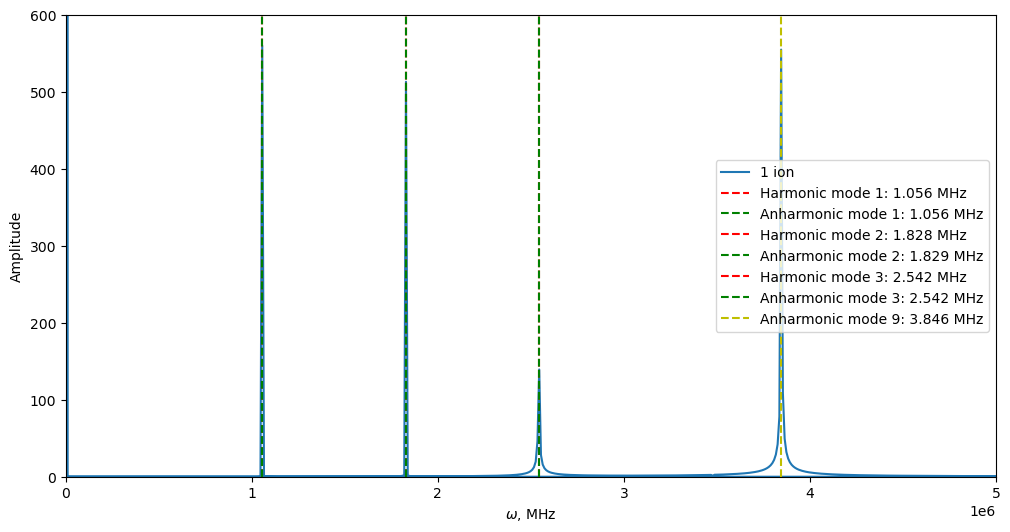

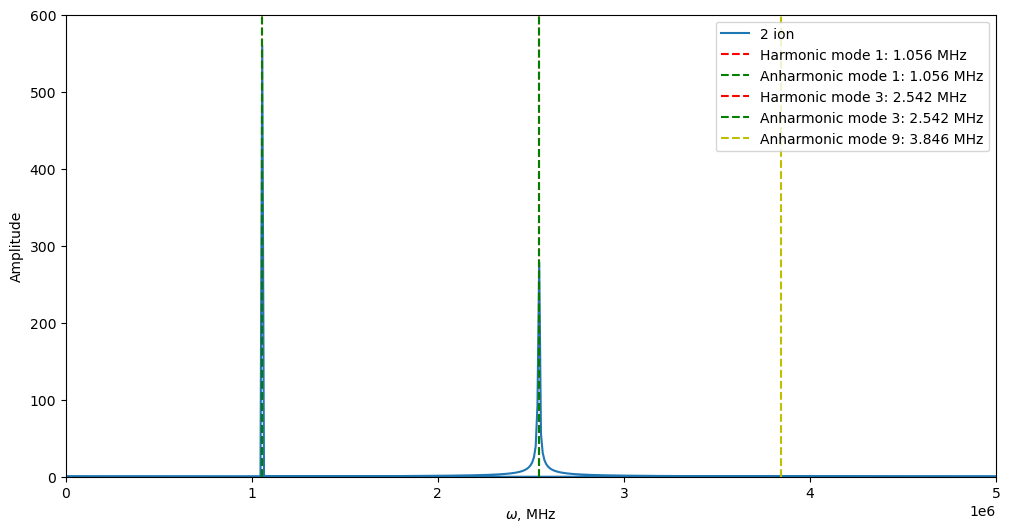

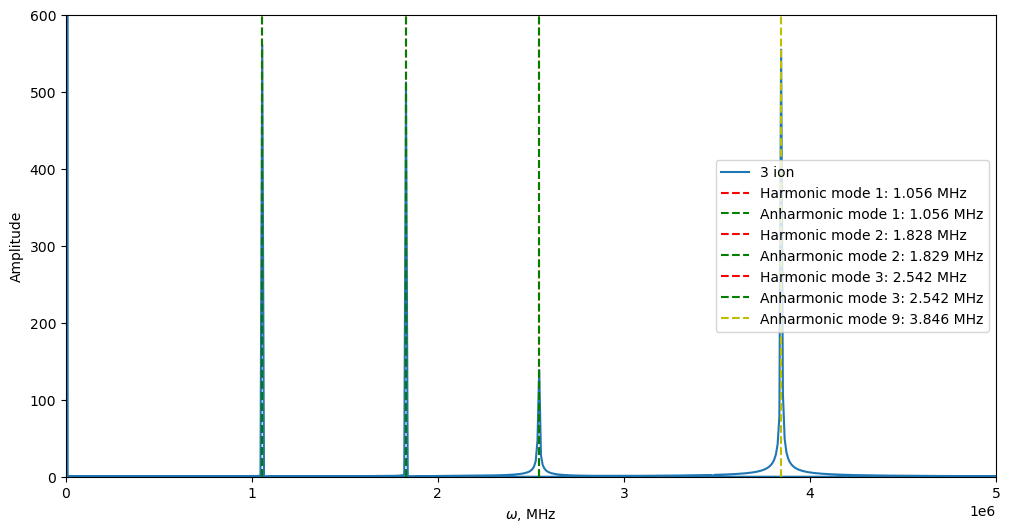

In [16]:
for n, ion_spectrum in enumerate(normal_spectrum_x):
    plt.figure(figsize = (12,6))
    plt.plot(freqsfft, ion_spectrum, label = f'{n+1} ion')
    for i, mode in enumerate(harm_modes[:ion_number]):
        if np.abs(mode[n]) > 0.1:
            plt.axvline(harm_freqs[i], c = 'r', ls = '--', label = f'Harmonic mode {i+1}: {np.round(harm_freqs[i]/1e6, 3)} MHz')
            plt.axvline(anh_freqs[i], c = 'g', ls = '--', label = f'Anharmonic mode {i+1}: {np.round(anh_freqs[i]/1e6, 3)} MHz')
    plt.axvline(anh_freqs[-1], c = 'y', ls = '--', label = f'Anharmonic mode {8+1}: {np.round(anh_freqs[-1]/1e6, 3)} MHz')
    plt.legend(loc = 'best')
    plt.xlabel('$\omega$, MHz')
    plt.xlim(0, 5e6)
    plt.ylim(0, 600)
    plt.ylabel('Amplitude')
    plt.show()

# Y modes

Here, the (green) anharmonic frequencies are closer to actual ones, up to the pseudopotential error.

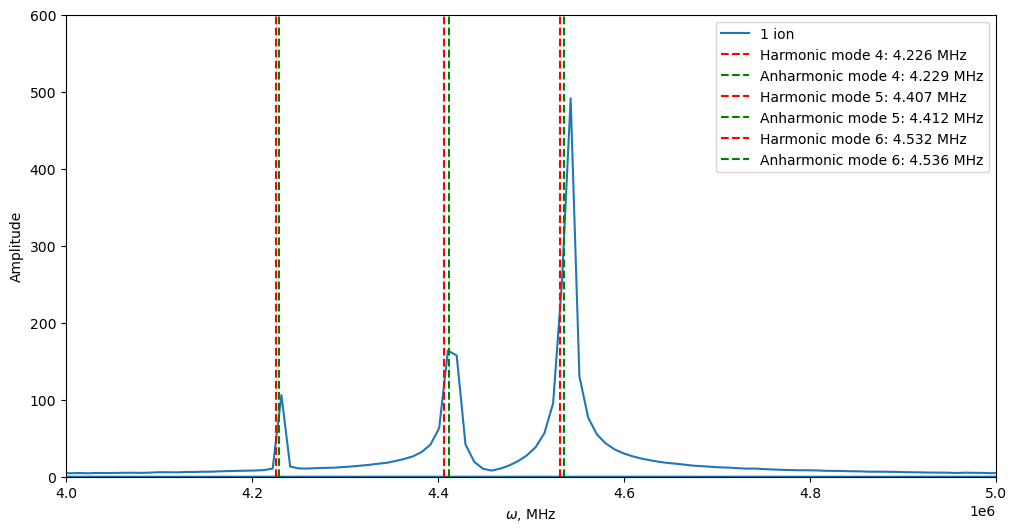

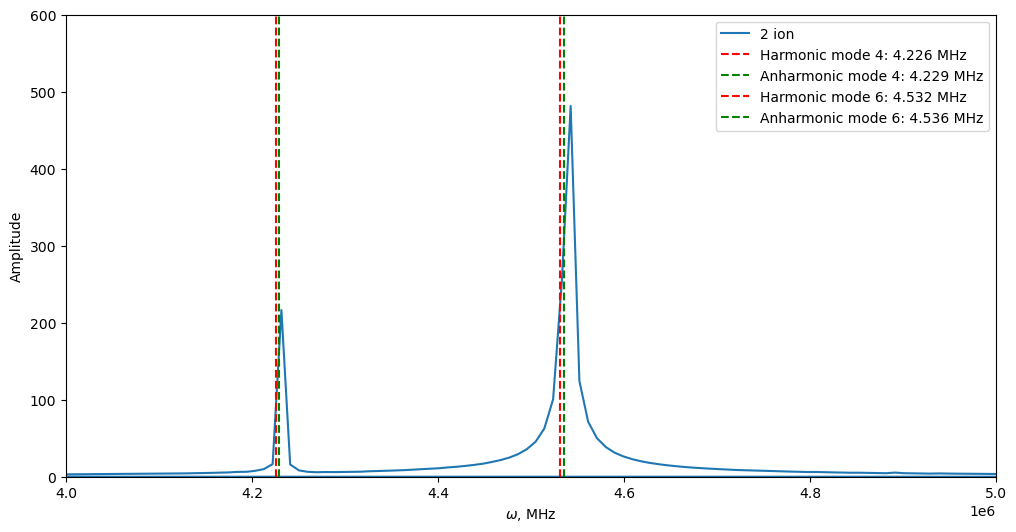

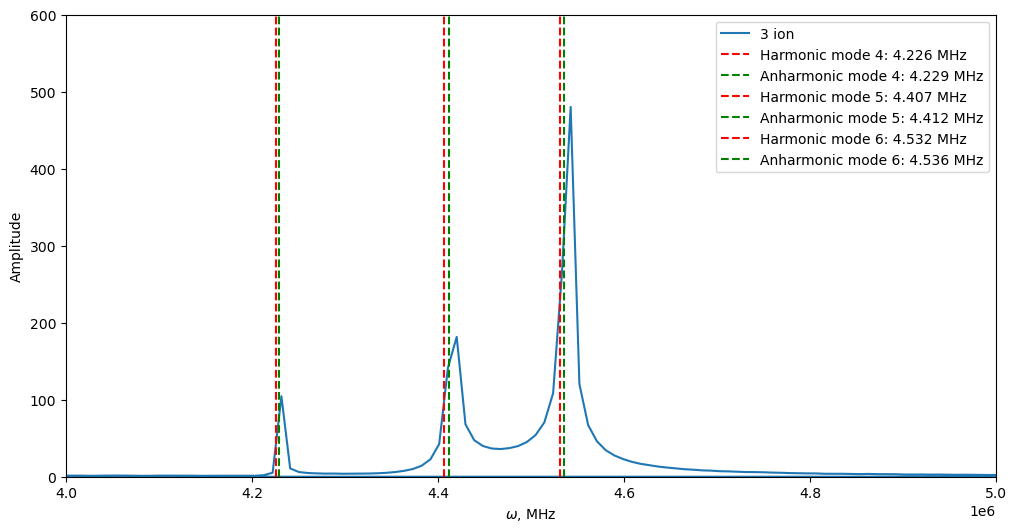

In [17]:
for n, ion_spectrum in enumerate(normal_spectrum_y):
    plt.figure(figsize = (12,6))
    plt.plot(freqsfft, ion_spectrum, label = f'{n+1} ion')
    for p, mode in enumerate(harm_modes[ion_number:2*ion_number]):
        i = p + ion_number
        if np.abs(mode[n+ion_number]) > 0.1:
            plt.axvline(harm_freqs[i], c = 'r', ls = '--', label = f'Harmonic mode {i+1}: {np.round(harm_freqs[i]/1e6, 3)} MHz')
            #plt.axvline(anh_freqs[i]*1.0242, c = 'g', ls = '--', label = f'Anharmonic mode {i+1}: {np.round(anh_freqs[i]/1e6*1.0242, 3)} MHz')
            plt.axvline(anh_freqs[i], c = 'g', ls = '--', label = f'Anharmonic mode {i+1}: {np.round(anh_freqs[i]/1e6, 3)} MHz')

    plt.legend(loc = 'best')
    plt.xlabel('$\omega$, MHz')
    plt.xlim(4e6, 5e6)
    plt.ylim(0, 600)
    plt.ylabel('Amplitude')
    plt.show()

## Z modes

Here, the anharmonic modes are even better in fitting the actual modes. The COM mode dominates the rest, so we are unable to observe them properly (especially the stretch Z mode). This partially due to ion starting positions, which favored the COM mode occupation more.

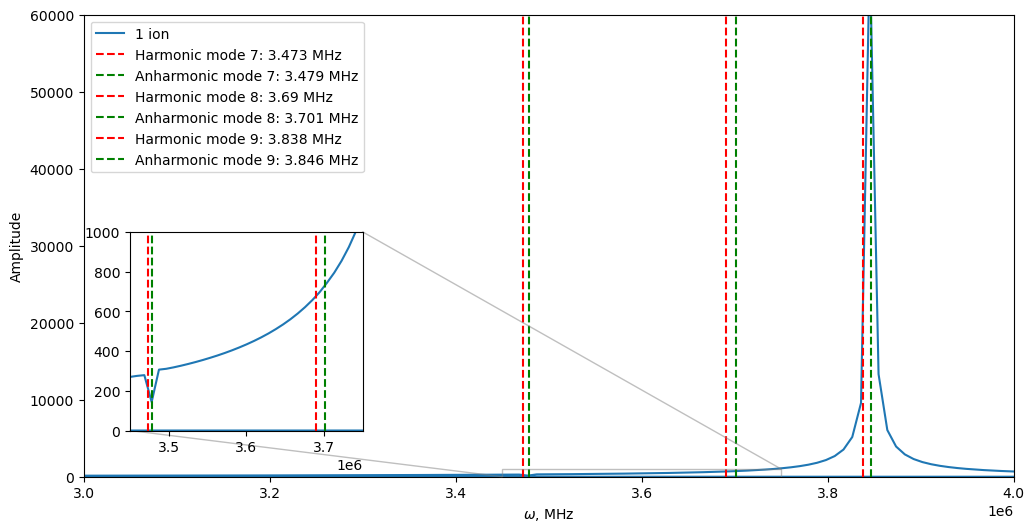

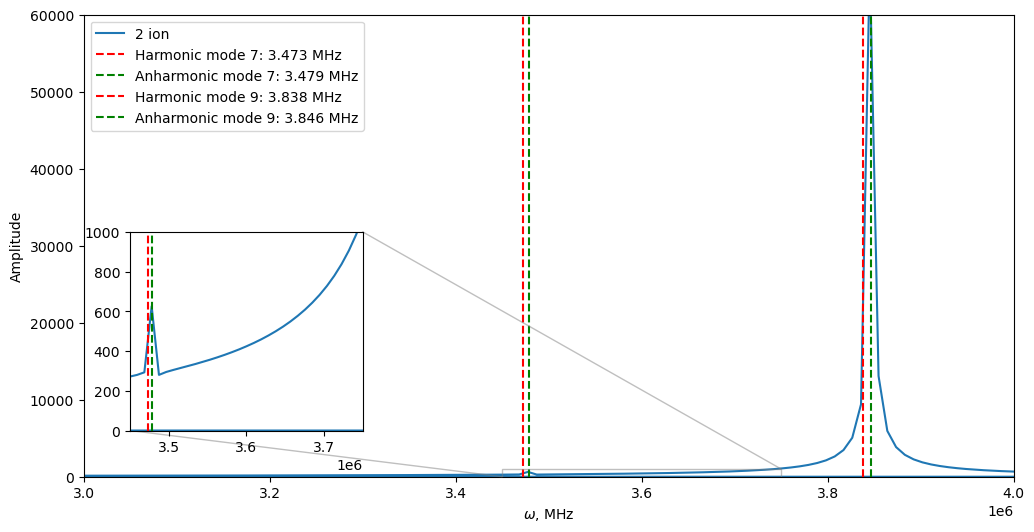

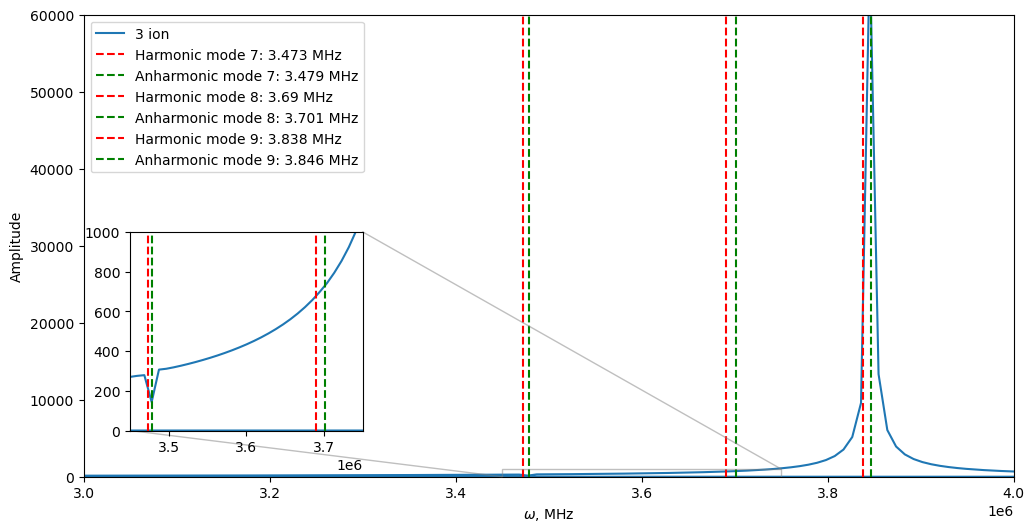

In [18]:
for n, ion_spectrum in enumerate(normal_spectrum_z):
    fig, ax = plt.subplots(1,1,figsize = (12,6))
    ax.plot(freqsfft, ion_spectrum, label = f'{n+1} ion')
    axins = ax.inset_axes([0.05, 0.1, 0.25, 0.43])

    axins.plot(freqsfft, ion_spectrum)

    # sub region of the original image
    x1, x2, y1, y2 = 3.45e6, 3.75e6, 0, 1000
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    
    for p, mode in enumerate(harm_modes[2*ion_number:]):
        i = p + 2*ion_number
        if np.abs(mode[n+2*ion_number]) > 0.1:
            ax.axvline(harm_freqs[i], c = 'r', ls = '--', label = f'Harmonic mode {i+1}: {np.round(harm_freqs[i]/1e6, 3)} MHz')
            #plt.axvline(anh_freqs[i]*(1.024), c = 'g', ls = '--', label = f'Anharmonic mode {i+1}: {np.round(anh_freqs[i]/1e6*(1.024), 3)} MHz')
            ax.axvline(anh_freqs[i], c = 'g', ls = '--', label = f'Anharmonic mode {i+1}: {np.round(anh_freqs[i]/1e6, 3)} MHz')
            axins.axvline(harm_freqs[i], c = 'r', ls = '--')
            #plt.axvline(anh_freqs[i]*(1.024), c = 'g', ls = '--', label = f'Anharmonic mode {i+1}: {np.round(anh_freqs[i]/1e6*(1.024), 3)} MHz')
            axins.axvline(anh_freqs[i], c = 'g', ls = '--')
    plt.legend(loc = 'best')
    
    ax.set_xlabel('$\omega$, MHz')
    ax.set_xlim(3e6, 4e6)
    ax.set_ylim(0, 60000)
    
#     axins.set_xticks(visible=False)
#     axins.set_yticks(visible=False)
    
    ax.set_ylabel('Amplitude')
    ax.indicate_inset_zoom(axins) 
    plt.show()